In [72]:
#Import All the dependencies for our project
import numpy as np
import pickle


def one_hot_encode(Y_data, classes):
  
    labels = np.zeros((len(Y_data), classes))
    for i, x in enumerate(Y_data):
        labels[i][x] = 1
    
    return labels

#Load all the data that we have made in our previous steps
with open('feature_vector_train.pkl', 'rb') as file:
    X = pickle.load(file)

with open('labels_train.pkl', 'rb') as file:
    Y_data = pickle.load(file)
    Y = one_hot_encode(Y_data,10)

with open('labels_test.pkl', 'rb') as file:
    Y_test_data = pickle.load(file)
    Y_test = one_hot_encode(Y_test_data,10)

with open('feature_vector_test.pkl', 'rb') as file:
    X_test = pickle.load(file)


#Initialize lists to store data at the time of training and testing on Original data
TrainingLoss_O = []
TrainingAccuracy_O = []
TestLoss_O= []
TestAccuracy_O = []

#Initialize lists to store data at the time of training and testing on Augmented data
TrainingLoss_A = []
TrainingAccuracy_A = []
TestLoss_A= []
TestAccuracy_A = []


In [73]:
#Activation function in our MLP

#Relu function used as an activation function after Hidden Layer 1 and Hidden Layer 2
def relu(z):
    return np.maximum(0,z)


#Activation function used after Output Layer 
def softmax(z):
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis = 1).reshape(z.shape[0], 1)


# Loss function
def lossFunction(y_label, y_pred):    
    return -np.sum(y_pred * np.log(y_label)) / y_pred.shape[0]
 
    
#Accuracy functions    
def accuracy(y_label, y_pred):
    return (np.argmax(y_pred, axis = 1) == np.argmax(y_label, axis=1)).mean()


In [76]:
#Initialize weights and bias for our MLP

#weights and bias for Hidden Layer 1

wh1 = (np.random.random((512,64)))/1e3
bh1 = np.zeros((1,64))

#weights and bias for Hidden Layer 1
wh2 = (np.random.random((64,64)))/1e3
bh2 = np.zeros((1,64))

#weights and bias for Hidden Layer 1
wo = (np.random.random((64,10)))/1e3
bo = np.zeros((1,10))

#Learning Rate of our MLP
lr = 0.01
epochs = 40


In [77]:
#Make batches of our data at the time of training

def makeBatch(X_vector,Y_label,size=64):
      
    X_batch = []
    Y_batch = []
    
    batches = int(np.ceil(len(X_vector) / size))
    
    for i in range(batches-1):
        X_batch.append(X_vector[i*size:(i+1)*size])
        Y_batch.append(Y_label[i*size:(i+1)*size])
        
    X_batch.append(X_vector[(i+1)*size:])
    Y_batch.append(Y_label[(i+1)*size:])
    
    return X_batch, Y_batch 

#Forward Propogation

def forward_propogation(X_vector):
    
    InputHidden1 = np.dot(X_vector,wh1)+bh1
    OutputHidden1 = relu(InputHidden1)

    InputHidden2 = np.dot(OutputHidden1,wh2)+bh2
    OutputHidden2 = relu(InputHidden2)

    InputOfOutput = np.dot(OutputHidden2,wo)+bo
    OutputOfOutputLayer = softmax(InputOfOutput)
    
    return OutputHidden1,OutputHidden2,OutputOfOutputLayer
    
#Backward Propogation and updation of weights

def backward_propogation(OutputHidden1,OutputHidden2,OutputOfOutputLayer,X_vector,Y_label):
    
    
    numOfSample = X_vector.shape[0] 
    global wo,bo,wh2,bh2,wh1,bh1
    
    #back propogation of outputs weights

    first_term = OutputOfOutputLayer - Y_label
    changes_output = np.dot(OutputHidden2.T, first_term) / numOfSample
    changes_output_bias = np.sum(first_term, axis=0) / numOfSample

    #back propogation of Hidden Layer 2 
    
    #gradient at level 2
    OutputHidden2[OutputHidden2>0] = 1                                
    g1 = OutputHidden2

    first_term_h2 = np.dot(first_term, wo.T) * g1                    
    changes_hidden_layer_2 = np.dot(OutputHidden1.T, first_term_h2) / numOfSample       
    changes_hidden_layer_2_bias = np.sum(first_term_h2, axis = 0) / numOfSample       

    #back propogation of Hidden Layer 1 
    
    #gradient at level 1
    OutputHidden1[OutputHidden1>0] = 1                                
    g0 = OutputHidden1

    first_term_h1 = np.dot(first_term_h2, wh2.T) * g0                    
    changes_hidden_layer_1 = np.dot(X_vector.T, first_term_h1) / numOfSample       
    changes_hidden_layer_1_bias = np.sum(first_term_h1, axis = 0) / numOfSample 


    #updates weights and bias at each level
    
    
    #updation at output layer
    wo = wo-lr*changes_output
    bo = bo-lr*changes_output_bias

    #updation at hidden layer 2
    wh2 = wh2-lr*changes_hidden_layer_2
    bh2 = bh2-lr*changes_hidden_layer_2_bias

    #updation at hidden layer 1
    wh1 = wh1 - lr*changes_hidden_layer_1
    bh1 = bh1 - lr*changes_hidden_layer_1_bias



In [78]:
#Train our Model by using Train data 

def train_MLP(X,Y,TrainingAccuracy,TrainingLoss,TestAccuracy,TestLoss):
    

    X_batch,Y_batch = makeBatch(X, Y, 32)
    batchLength = len(X_batch)

    for i in range(epochs):

        overall_Loss = 0
        overall_accuracy = 0

        for itr in range(batchLength):

            X_vector, Y_label = X_batch[itr], Y_batch[itr]
            numOfSample = X_vector.shape[0] 

            OutputHidden1,OutputHidden2,OutputOfOutputLayer = forward_propogation(X_vector)

            backward_propogation(OutputHidden1,OutputHidden2,OutputOfOutputLayer,X_vector,Y_label)

            Loss = lossFunction(OutputOfOutputLayer,Y_label)

            Accuracy = accuracy(OutputOfOutputLayer,Y_label)

            overall_accuracy += Accuracy * numOfSample
            overall_Loss += Loss * numOfSample

        eachEpochLoss = overall_Loss/X.shape[0]       
        eachEpochAcc = overall_accuracy/X.shape[0] 


        TrainingAccuracy.append(eachEpochAcc*100)            
        TrainingLoss.append(eachEpochLoss) 

        OutputHidden1,OutputHidden2,OutputOfOutputLayer = forward_propogation(X_test)

        testAccuracy = accuracy(OutputOfOutputLayer,Y_test)
        testLoss = lossFunction(OutputOfOutputLayer,Y_test)


        TestAccuracy.append(testAccuracy*100)
        TestLoss.append(testLoss*100)

        #Printing status of training after every 10 epochs.
        if i == 0 or (i + 1)%10 == 0 or i == 999:       
            print("Epoch number: {:d}, Training Accuracy : {:.3f}, Training Loss : {:.3f} ".format(i + 1,eachEpochAcc*100, eachEpochLoss))
      

        
#best result at 0.01,32,100



In [79]:
# train data on Original Data

print("Traing and Testing Results on Original Data")

train_MLP(X[:50000],Y[:50000],TrainingAccuracy_O,TrainingLoss_O,TestAccuracy_O,TestLoss_O)

OutputHidden1,OutputHidden2,OutputOfOutputLayer = forward_propogation(X_test)

Accuracy = accuracy(OutputOfOutputLayer,Y_test)

print("Accuracy on the testing data after traing on Original Data is ",Accuracy*100)
original_result.append(Accuracy*100)
#train data on Augmented Data

print("Traing and Testing  Results on Augmented Data")
train_MLP(X[50000:],Y[50000:],TrainingAccuracy_A,TrainingLoss_A,TestAccuracy_A,TestLoss_A)


OutputHidden1,OutputHidden2,OutputOfOutputLayer = forward_propogation(X_test)

Accuracy = accuracy(OutputOfOutputLayer,Y_test)
aug_result.append(Accuracy*100)
print("Accuracy on the testing data after training on Augmented Data is",Accuracy*100)

Traing and Testing Results on Original Data
Epoch number: 1, Training Accuracy : 9.760, Training Loss : 2.303 
Epoch number: 10, Training Accuracy : 32.488, Training Loss : 1.561 
Epoch number: 20, Training Accuracy : 74.012, Training Loss : 0.749 
Epoch number: 30, Training Accuracy : 79.652, Training Loss : 0.584 
Epoch number: 40, Training Accuracy : 81.708, Training Loss : 0.527 
Accuracy on the testing data after traing on Original Data is  67.135
Traing and Testing  Results on Augmented Data
Epoch number: 1, Training Accuracy : 62.952, Training Loss : 1.054 
Epoch number: 10, Training Accuracy : 69.396, Training Loss : 0.863 
Epoch number: 20, Training Accuracy : 71.514, Training Loss : 0.802 
Epoch number: 30, Training Accuracy : 73.200, Training Loss : 0.758 
Epoch number: 40, Training Accuracy : 74.452, Training Loss : 0.723 
Accuracy on the testing data after training on Augmented Data is 77.01


In [55]:
#Testing Phase for our MLP


In [56]:
#Results after using SVM Classifier KNN Classifier Logistic Regression Classifier Decision Tree Classifier


In [57]:
from sklearn.metrics import accuracy_score


Y_data = np.array(Y_data)
print(Y_data.shape)
Y_test_data = np.array(Y_test_data)
print(Y_test_data.shape)

#SVM Classifier
from sklearn import svm


#Predicting on original data
classifier1 = svm.LinearSVC(max_iter =1000) 
classifier1.fit(X[:50000], Y_data[:50000])
y_pred = classifier1.predict(X_test)

Acc = accuracy_score(Y_test_data, y_pred)
original_result.append(Acc*100)
print("Accuracy on Original Data :",Acc*100)

(100000,)
(20000,)
Accuracy on Original Data : 77.84


/home/madhavm0706/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [58]:
#Predictiong on augmented data

classifier2 = svm.LinearSVC(max_iter =1000) 
classifier2.fit(X,Y_data)
y_pred_aug = classifier2.predict(X_test)

Acc = accuracy_score(Y_test_data, y_pred_aug)
aug_result.append(Acc*100)
print("Accuracy on Augmented Data :",Acc*100)

Accuracy on Augmented Data : 75.79


/home/madhavm0706/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [59]:
from sklearn.metrics import accuracy_score

#KNN Classifier
from sklearn.neighbors import KNeighborsClassifier



#Predicting on original data

classifier1 = KNeighborsClassifier()
classifier1.fit(X[:50000], Y_data[:50000])
y_pred = classifier1.predict(X_test)


Acc = accuracy_score(Y_test_data, y_pred)
original_result.append(Acc*100)

print("Accuracy on Original Data :",Acc*100)

#Predictiong on augmented data
classifier2 = KNeighborsClassifier()
classifier2.fit(X,Y_data)
y_pred_aug = classifier2.predict(X_test)



Acc = accuracy_score(Y_test_data, y_pred_aug)
aug_result.append(Acc*100)

print("Accuracy on Augmented Data :",Acc*100)


Accuracy on Original Data : 69.38
Accuracy on Augmented Data : 68.05


In [60]:
#Logistic Regression

from sklearn.linear_model import LogisticRegression



#Predicting on original data
classifier1 = LogisticRegression(random_state=42,multi_class='ovr',max_iter =1000)
classifier1.fit(X[:50000],Y_data[:50000])
y_pred = classifier1.predict(X_test)


Acc = accuracy_score(Y_test_data, y_pred)
original_result.append(Acc*100)
print("Accuracy on Original Data :",Acc*100)

#Predicting on augmented data
classifier2 = LogisticRegression(random_state=42,multi_class='ovr',max_iter =1000)
classifier2.fit(X,Y_data)
y_pred_aug = classifier2.predict(X_test)


Acc = accuracy_score(Y_test_data, y_pred_aug)
aug_result.append(Acc*100)
print("Accuracy on Augmented Data :",Acc*100)

Accuracy on Original Data : 78.64999999999999
Accuracy on Augmented Data : 78.16


In [61]:
#Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier


#Predicting on original data
classifier1 = DecisionTreeClassifier(max_depth =12, random_state = 42)
classifier1.fit(X[:50000], Y_data[:50000])
y_pred = classifier1.predict(X_test)

Acc = accuracy_score(Y_test_data,y_pred)
original_result.append(Acc*100)
print("Accuracy on Original Data :",Acc*100)

#Predicting on augmented data

classifier2 = DecisionTreeClassifier(max_depth =12, random_state = 42)
classifier2.fit(X, Y_data)
y_pred_aug = classifier2.predict(X_test)


Acc = accuracy_score(Y_test_data,y_pred_aug)
aug_result.append(Acc*100)
print("Accuracy on Augmented Data :",Acc*100)


Accuracy on Original Data : 48.339999999999996
Accuracy on Augmented Data : 48.010000000000005


[67.285, 77.42999999999999, 69.38, 78.64999999999999, 48.339999999999996, 67.595, 77.84, 69.38, 78.64999999999999, 48.339999999999996]


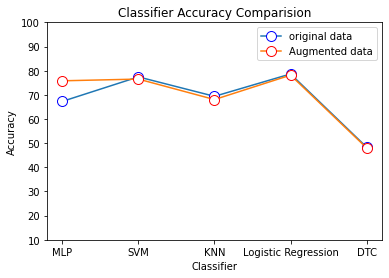

[67.285, 77.42999999999999, 69.38, 78.64999999999999, 48.339999999999996, 67.595, 77.84, 69.38, 78.64999999999999, 48.339999999999996]
[75.81, 76.52, 68.05, 78.16, 48.010000000000005, 75.64999999999999, 75.79, 68.05, 78.16, 48.010000000000005]


In [70]:
import matplotlib.pyplot as plt

classifier_names = ['MLP','SVM', 'KNN', 'Logistic Regression', 'DTC']


plt.plot( classifier_names,original_result, marker="o", markersize=10, markeredgecolor="blue", markerfacecolor="white", label='original data')
plt.plot( classifier_names,aug_result, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="white", label='Augmented data')
  
# Naming the x-axis, y-axis and the whole graph
plt.ylabel("Accuracy")
plt.xlabel("Classifier")
plt.title("Classifier Accuracy Comparision")
plt.ylim(10, 100)

  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()



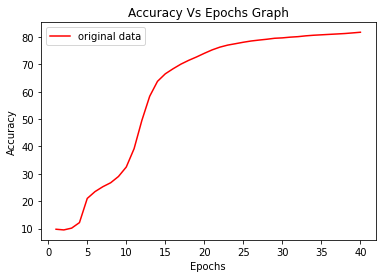

In [81]:

Epochs = []

for i in range(40):
    Epochs.append(i+1)

plt.plot( Epochs,TrainingAccuracy_O, color='r', label='original data')

  
# Naming the x-axis, y-axis and the whole graph
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Accuracy Vs Epochs Graph")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

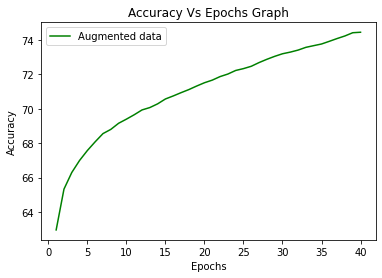

In [82]:

plt.plot(Epochs,TrainingAccuracy_A, color='g', label='Augmented data')

# Naming the x-axis, y-axis and the whole graph
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Accuracy Vs Epochs Graph")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

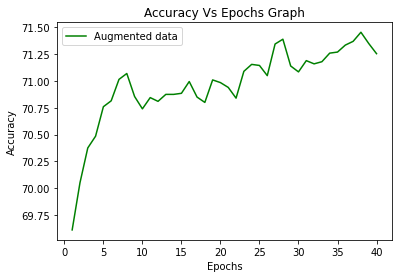

In [85]:


plt.plot(Epochs,TestAccuracy_A, color='g', label='Augmented data')

# Naming the x-axis, y-axis and the whole graph
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Accuracy Vs Epochs Graph")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

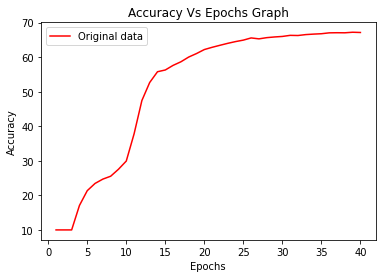

In [86]:

plt.plot(Epochs,TestAccuracy_O, color='r', label='Original data')

# Naming the x-axis, y-axis and the whole graph
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Accuracy Vs Epochs Graph")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()